In [1]:
import torch, torchvision
import torch.nn.functional as F
from torch.optim import SGD,Adam,AdamW
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA
from torch import optim

from oil.datasetup.datasets import split_dataset
from oil.utils.utils import Eval, LoaderTo, cosLr, dmap, FixedNumpySeed, FixedPytorchSeed

from flow_ssl.realnvp import RealNVPTabular
from flow_ssl.data.nlp_datasets import AG_News,YAHOO

from utils import swa_learning_rate
from swag.utils import calibration_curve
from models import RealNVPTabularWPrior, RealNVPTabularSWAG, SemiFlow, SemiFlowSWAG
from flowgmm_trainer import make_trainer
from ensembles import SWAG_Results, Ensembles
from swag.posteriors import SWAG
from temperature_scaling import ModelWithTemperature, EnsemblesWithTemperature

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

import warnings

In [2]:
# def makeTrainer(train_data, test_data, bs=5000, split={'train':200,'val':5000},
#                 network=RealNVPTabularWPrior, net_config={}, num_epochs=15,
#                 optim=AdamW, lr=1e-3, opt_config={'weight_decay':1e-5},
#                 swag=False, swa_config={'swa_dec_pct':.5, 'swa_start_pct':.75, 'swa_freq_pct':.05, 'swa_lr_factor':.1},
#                 swag_config={'subspace':'covariance', 'max_num_models':20},
#                 trainer=SemiFlow, trainer_config={'log_dir':os.path.expanduser('~/tb-experiments/UCI/'),'log_args':{'minPeriod':.1, 'timeFrac':3/10}},
#                 dev='cuda', save=False):
#     with FixedNumpySeed(0):
#         datasets = split_dataset(train_data,splits=split)
#         datasets['_unlab'] = dmap(lambda mb: mb[0],train_data)
#         datasets['test'] = test_data
        
#     device = torch.device(dev)
    
#     dataloaders = {k : LoaderTo(DataLoader(v,
#                                          batch_size=min(bs,len(datasets[k])),
#                                          shuffle=(k=='train'),
#                                          num_workers=0,
#                                          pin_memory=False),
#                               device) 
#                    for k, v in datasets.items()}
#     dataloaders['Train'] = dataloaders['train']

#     opt_constr = partial(optim, lr=lr, **opt_config)
#     model = network(num_classes=train_data.num_classes, dim_in=train_data.dim, **net_config).to(device)
#     if swag:
#         swag_model = RealNVPTabularSWAG(dim_in=train_data.dim, **net_config, **swag_config)
#         swag_model.to(device)
#         swa_config['steps_per_epoch'] = len(dataloaders['_unlab'])
#         swa_config['num_epochs'] = num_epochs
#         lr_sched = swa_learning_rate(**swa_config)
# #         lr_sched = cosLr(num_epochs)
#         return trainer(model,dataloaders, opt_constr,lr_sched, swag_model=swag_model, **swa_config, **trainer_config)
#     else:
# #         model = network(num_classes=train_data.num_classes, dim_in=train_data.dim, **net_config).to(device)
#         lr_sched = cosLr(num_epochs)
#     #     lr_sched = lambda e:1
#         return trainer(model,dataloaders, opt_constr,lr_sched, **trainer_config)

In [3]:
dataset = AG_News
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 70
lr=3e-4

trainers=[
    make_trainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':200,'val':100},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.6, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':2, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

ensembles = Ensembles(trainers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)
        
    ensembles.update_results(num_epochs, calibration=False)

Pairwise dists: [[ 0.         22.1978683  22.30576979 22.759236  ]
 [22.1978683   0.         22.91233833 22.96197502]
 [22.30576979 22.91233833  0.         22.82317483]
 [22.759236   22.96197502 22.82317483  0.        ]]
Pairwise dists: [[ 0.         22.2072521  22.70802411 21.13793808]
 [22.2072521   0.         23.31955355 22.83915224]
 [22.70802411 23.31955355  0.         21.44299311]
 [21.13793808 22.83915224 21.44299311  0.        ]]
Pairwise dists: [[ 0.         21.48049497 21.29854844 21.68211411]
 [21.48049497  0.         23.32257864 22.26524804]
 [21.29854844 23.32257864  0.         22.48667868]
 [21.68211411 22.26524804 22.48667868  0.        ]]


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1739.129272      0.185     1079.158936  0.0003  0.223158     0.23   

     val_bpd  
0  10.029712  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
467    -2098.825439        1.0    -1267.828369  0.000247  0.807368     0.84   

      val_bpd  
467  5.591655  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
936    -2401.928223        1.0    -1367.685913  0.000123  0.821053     0.82   

      val_bpd  
936  5.400083  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1402    -2530.748047        1.0    -1405.613281  0.00002  0.827368     0.83   

       val_bpd  
1402  5.326044  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1679             NaN        1.0             NaN  3.000000e-07  0.826184   

      val_Acc   val_bpd  
1679     0.83  5.318078  


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1728.012085       0.24     1074.373413  0.0003  0.246316     0.16   

     val_bpd  
0  10.019501  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
467    -2070.628906        1.0    -1258.547607  0.000247  0.807237     0.86   

      val_bpd  
467  5.601159  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
936     -2392.11499        1.0    -1373.842285  0.000123  0.826053     0.84   

      val_bpd  
936  5.383035  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1406    -2523.963135        1.0    -1409.772705  0.000019     0.825     0.85   

       val_bpd  
1406  5.315946  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1679             NaN        1.0             NaN  3.000000e-07  0.824868   

      val_Acc   val_bpd  
1679     0.85  5.305758  


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1724.499756       0.33      1066.79895  0.0003      0.25     0.23   

     val_bpd  
0  10.005426  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
470    -2066.481934        1.0    -1258.426392  0.000246  0.810395     0.81   

      val_bpd  
470  5.612239  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
939    -2384.161865        1.0    -1365.768921  0.000123  0.821711     0.84   

      val_bpd  
939  5.401518  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1407    -2509.458984        1.0     -1404.27417  0.000019  0.818684     0.83   

       val_bpd  
1407  5.324717  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1679             NaN        1.0             NaN  3.000000e-07  0.820395   

      val_Acc   val_bpd  
1679     0.83  5.321775  


In [4]:
results = ensembles.results
num_models = results['Number of models']
for i in range(num_models):
    print("Test accuracy of model {}: {}".format(i+1, results['Model {}'.format(i+1)][-1]))
print("Test accuracy of Deep Ensembles model: {}".format(results['Deep Ensembles-{}'.format(num_models)][-1]))
print("Test accuracy of Flow Ensembles model: {}".format(results['Flow Ensembles-{}'.format(num_models)][-1]))

Test accuracy of model 1: 0.8261842105263157
Test accuracy of model 2: 0.8248684210526316
Test accuracy of model 3: 0.8203947368421053
Test accuracy of Deep Ensembles model: 0.8310526315789474
Test accuracy of Flow Ensembles model: 0.8348684210526316


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    scaled_models = [ModelWithTemperature(trainer) for trainer in trainers]
    
    for index, model in enumerate(scaled_models):
        print("Model {}".format(index+1))
        model.set_temperature()
    print("Flow Ensembles")
    flow_scaled_model = EnsemblesWithTemperature(trainers)
    flow_scaled_model.set_temperature()

Model 1
Validation - Before temperature - NLL: 5.791, ECE: 0.167
Optimal temperature: 12.259
Validation - After temperature - NLL: 0.549, ECE: 0.113
Test - Before temperature - NLL: 8.635, ECE: 0.170
Test - After temperature - NLL: 0.779, ECE: 0.113
Model 2
Validation - Before temperature - NLL: 6.422, ECE: 0.159
Optimal temperature: 12.968
Validation - After temperature - NLL: 0.584, ECE: 0.116
Test - Before temperature - NLL: 8.473, ECE: 0.170
Test - After temperature - NLL: 0.737, ECE: 0.108
Model 3
Validation - Before temperature - NLL: 5.826, ECE: 0.170
Optimal temperature: 12.283
Validation - After temperature - NLL: 0.564, ECE: 0.102
Test - Before temperature - NLL: 8.722, ECE: 0.176
Test - After temperature - NLL: 0.787, ECE: 0.117
Flow Ensembles
Validation - Before temperature - NLL: 5.225, ECE: 0.150
Optimal temperature: 11.572
Validation - After temperature - NLL: 0.532, ECE: 0.128
Test - Before temperature - NLL: 7.905, ECE: 0.161
Test - After temperature - NLL: 0.755, ECE:

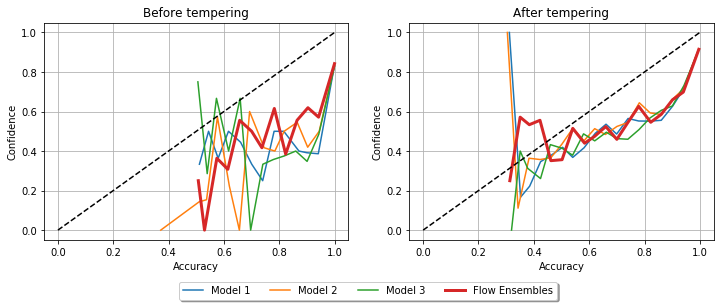

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_before
    ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())
    
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_after
    ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())

calibration_dict = flow_scaled_model.out_before
ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

calibration_dict = flow_scaled_model.out_after
ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

# print(calibration_dict["ece"].item())
ax1.set(xlabel='Accuracy', ylabel='Confidence', title="Before tempering")
ax1.plot([0, 1], [0, 1], "--k")
ax2.set(xlabel='Accuracy', ylabel='Confidence', title="After tempering")
ax2.plot([0, 1], [0, 1], "--k")

ax1.grid()
ax2.grid()
plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

In [8]:
# dataset = AG_News
dataset = YAHOO
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 150
lr=3e-4

trainers=[
    make_trainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':800,'val':400},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.2, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':3, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

ensembles = Ensembles(trainers)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)
        
    ensembles.update_results(num_epochs, calibration=False)

Pairwise dists: [[ 0.         22.34867873 22.85443149 23.61877653 22.20399835 22.16382402
  21.96007811 21.88450709 21.97079385 22.21492935]
 [22.34867873  0.         22.8803121  22.96167098 21.92187553 21.88851354
  21.72785708 21.52773586 22.63803267 21.48064019]
 [22.85443149 22.8803121   0.         23.08089186 22.66188596 21.88369433
  22.38042356 21.31146061 21.85159371 22.02997187]
 [23.61877653 22.96167098 23.08089186  0.         23.21233413 21.80942761
  23.22525199 21.88979871 22.59324607 23.77832831]
 [22.20399835 21.92187553 22.66188596 23.21233413  0.         22.02494875
  21.82466613 21.02889999 22.09707201 22.30770226]
 [22.16382402 21.88851354 21.88369433 21.80942761 22.02494875  0.
  22.05989731 21.76755883 21.19524949 22.4163061 ]
 [21.96007811 21.72785708 22.38042356 23.22525199 21.82466613 22.05989731
   0.         22.08149086 22.16402327 22.3688379 ]
 [21.88450709 21.52773586 21.31146061 21.88979871 21.02889999 21.76755883
  22.08149086  0.         21.47443279 21.84

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1298.353271       0.11     1071.919678  0.0003    0.0892   0.0975   

    val_bpd  
0  10.01209  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
462    -1596.832397      0.915    -1345.938599  0.000235    0.5723   0.5875   

     val_bpd  
462  5.46346  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
920    -1808.019531    0.99875    -1453.330322  0.000098    0.5699    0.575   

      val_bpd  
920  5.248995  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1370    -1878.665527        1.0    -1488.033203  0.000006    0.5767     0.59   

       val_bpd  
1370  5.184283  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1499             NaN        1.0             NaN  3.000000e-07    0.5763   

      val_Acc   val_bpd  
1499    0.585  5.182878  


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1291.957397    0.11625     1061.793945  0.0003    0.1003   0.1275   

    val_bpd  
0  9.992963  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
451    -1591.209473    0.91125    -1336.475464  0.000238    0.5683   0.5825   

      val_bpd  
451  5.470814  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
902    -1805.049072    0.99375    -1453.945312  0.000103    0.5731   0.5975   

      val_bpd  
902  5.258107  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1354    -1878.172729        1.0    -1487.508911  0.000007    0.5795    0.605   

       val_bpd  
1354  5.188794  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1499             NaN        1.0             NaN  3.000000e-07    0.5804   

      val_Acc   val_bpd  
1499    0.605  5.185851  


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
0     1297.597412     0.0925     1064.272217  0.0003    0.0971   0.0825   

    val_bpd  
0  9.997685  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
461    -1588.434814     0.8975    -1333.351807  0.000236    0.5639   0.5775   

      val_bpd  
461  5.476535  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
919    -1802.207764    0.99875    -1450.881226  0.000098    0.5813    0.595   

      val_bpd  
919  5.255133  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)       lr0  test_Acc  val_Acc  \
1377    -1874.174194        1.0    -1484.102905  0.000005    0.5761   0.5975   

       val_bpd  
1377  5.189675  

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)           lr0  test_Acc  \
1499             NaN        1.0             NaN  3.000000e-07    0.5776   

      val_Acc  val_bpd  
1499    0.595  5.18825  


In [9]:
results = ensembles.results
num_models = results['Number of models']
for i in range(num_models):
    print("Test accuracy of model {}: {}".format(i+1, results['Model {}'.format(i+1)][-1]))
print("Test accuracy of Deep Ensembles model: {}".format(results['Deep Ensembles-{}'.format(num_models)][-1]))
print("Test accuracy of Flow Ensembles model: {}".format(results['Flow Ensembles-{}'.format(num_models)][-1]))

Test accuracy of model 1: 0.5763
Test accuracy of model 2: 0.5804
Test accuracy of model 3: 0.5776
Test accuracy of Deep Ensembles model: 0.5925
Test accuracy of Flow Ensembles model: 0.5942


In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    scaled_models = [ModelWithTemperature(trainer) for trainer in trainers]
    
    for index, model in enumerate(scaled_models):
        print("Model {}".format(index+1))
        model.set_temperature()
    print("Flow Model")
    flow_scaled_model = EnsemblesWithTemperature(trainers)
    flow_scaled_model.set_temperature()

Model 1
Validation - Before temperature - NLL: 18.973, ECE: 0.404
Optimal temperature: 23.563
Validation - After temperature - NLL: 1.338, ECE: 0.071
Test - Before temperature - NLL: 19.156, ECE: 0.407
Test - After temperature - NLL: 1.400, ECE: 0.040
Model 2
Validation - Before temperature - NLL: 18.773, ECE: 0.377
Optimal temperature: 23.398
Validation - After temperature - NLL: 1.354, ECE: 0.065
Test - Before temperature - NLL: 18.496, ECE: 0.403
Test - After temperature - NLL: 1.384, ECE: 0.038
Model 3
Validation - Before temperature - NLL: 18.386, ECE: 0.396
Optimal temperature: 23.129
Validation - After temperature - NLL: 1.345, ECE: 0.069
Test - Before temperature - NLL: 18.650, ECE: 0.406
Test - After temperature - NLL: 1.394, ECE: 0.042
Flow Model
Validation - Before temperature - NLL: 17.151, ECE: 0.378
Optimal temperature: 22.240
Validation - After temperature - NLL: 1.286, ECE: 0.076
Test - Before temperature - NLL: 17.076, ECE: 0.390
Test - After temperature - NLL: 1.329, 

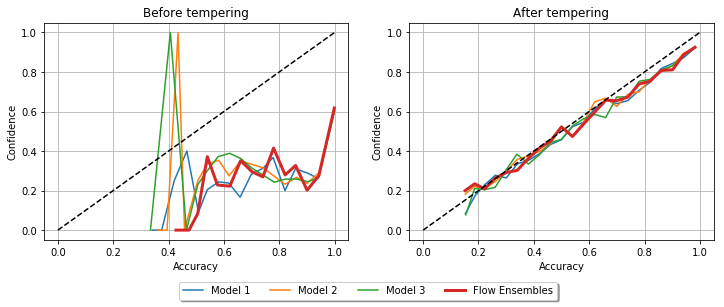

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 4))
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_before
    ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())
    
for index, model in enumerate(scaled_models):
    calibration_dict = model.out_after
    ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
     label="Model {}".format(index+1), color='C{}'.format(index))
#     print(calibration_dict["ece"].item())

calibration_dict = flow_scaled_model.out_before
ax1.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

calibration_dict = flow_scaled_model.out_after
ax2.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
 label="Flow Ensembles", lw=3, markersize=12, color='C3')

# print(calibration_dict["ece"].item())
ax1.set(xlabel='Accuracy', ylabel='Confidence', title="Before tempering")
ax1.plot([0, 1], [0, 1], "--k")
ax2.set(xlabel='Accuracy', ylabel='Confidence', title="After tempering")
ax2.plot([0, 1], [0, 1], "--k")

ax1.grid()
ax2.grid()
plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

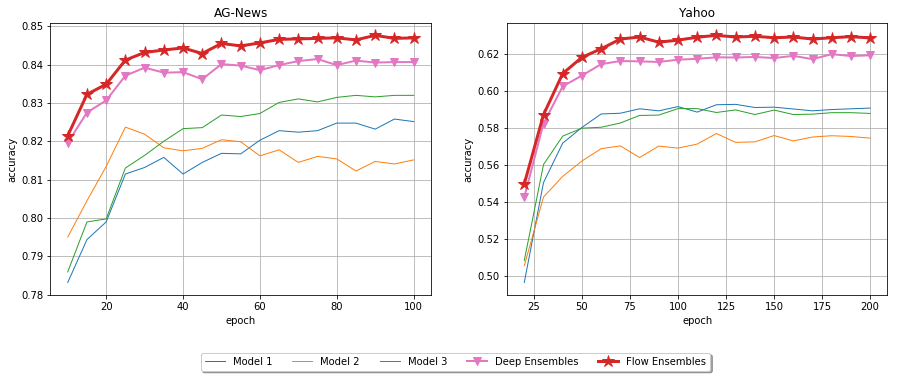

In [4]:
results_ag = Ensembles.load_results('results/AG_News-ensembles-002.json')
results_yahoo = Ensembles.load_results('results/YAHOO-ensembles-538.json')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
# fig, ax = plt.subplots(figsize=(8, 6))
Ensembles.plot_results(results_ag, ax1, 'AG-News', start=1)
Ensembles.plot_results(results_yahoo, ax2, 'Yahoo', start=1)

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

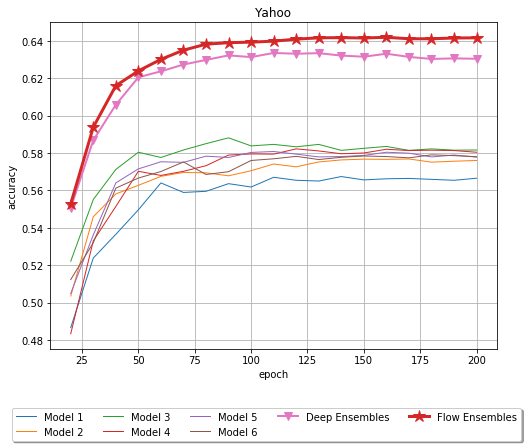

In [11]:
results_yahoo = Ensembles.load_results('results/YAHOO-ensembles-365.json')

# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig, ax = plt.subplots(figsize=(8, 6))
# Ensembles.plot_results(results_ag, ax1, 'Yahoo', start=2)
Ensembles.plot_results(results_yahoo, ax, 'Yahoo', start=1)

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()